In [128]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum, first
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.ml.regression import LinearRegression
import pyspark

In [129]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [130]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [131]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [132]:
cluster_feature = sqlcontext.read.csv(path=base_path+"bk=8_means_Feature.csv",header=True,inferSchema=True)
# cluster_feature = cluster_feature.drop("_c0","date2","diff_energy_week_t_1","rnk","month")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (

In [133]:
cluster_feature.where(cluster_feature.cluster_id == 1).select("energy(kWh/h)").show(10)

+-------------+
|energy(kWh/h)|
+-------------+
|      265.413|
|       217.73|
|      176.672|
|      151.297|
|      139.542|
|      140.463|
|      152.272|
|      171.886|
|      212.541|
|      261.072|
+-------------+
only showing top 10 rows



In [134]:
cluster_feature1 = sqlcontext.read.csv(path=base_path+"cluster_info_b-k_means_k-8.csv",header=True,inferSchema=True)
#cluster_feature1.where(cluster_feature1.cluster_id==7).select("LCLid").show()
cluster_feature1.groupBy("cluster_id").count().show()

+----------+-----+
|cluster_id|count|
+----------+-----+
|         1|  940|
|         6|   75|
|         3|  652|
|         5|  209|
|         4|  501|
|         7|   14|
|         2|  738|
|         0|  801|
+----------+-----+



In [135]:
cluster_feature = cluster_feature.withColumn("holiday1",sf.when((col("Weekday/end")==1) | (col("holiday")==1),1).otherwise(0))
cluster_feature = cluster_feature.drop("_c0","diff_energy_week_t_1","date2","holiday","month","Weekday/end")
cluster_feature = cluster_feature.withColumnRenamed("holiday1","holiday")
cluster_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, rnk=32, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3

In [136]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_d

In [137]:
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

59

In [138]:
feature_col

['humidity',
 'category_weekDay_index',
 'min_7',
 'max_3',
 'max_4',
 'windSpeed',
 'pressure',
 '5_diff_energy_t_1',
 '7_diff_energy_t_2',
 'diff_energy_week_t_4',
 'mean_1',
 'max_6',
 '1_diff_energy_t_2',
 '3_diff_energy_t_0',
 'max_1',
 'min_6',
 '3_diff_energy_t_2',
 'mean_4',
 'hour',
 '5_diff_energy_t_0',
 'mean_2',
 'min_1',
 'holiday',
 '4_diff_energy_t_0',
 '6_diff_energy_t_0',
 'min_3',
 'category_summary_index',
 'min_2',
 '4_diff_energy_t_2',
 'mean_3',
 'diff_energy_week_t_2',
 'temperatureMin',
 'mean_5',
 'diff_energy_week_t_3',
 '7_diff_energy_t_1',
 'visibility',
 '2_diff_energy_t_2',
 '1_diff_energy_t_1',
 'windBearing',
 '7_diff_energy_t_0',
 'min_5',
 'mean_6',
 'max_7',
 'dewPoint',
 '3_diff_energy_t_1',
 '6_diff_energy_t_1',
 'mean_7',
 'min_4',
 '2_diff_energy_t_0',
 '1_diff_energy_t_0',
 'max_2',
 'apparentTemperature',
 '5_diff_energy_t_2',
 'temperatureMax',
 'category_precipType_index',
 '4_diff_energy_t_1',
 'max_5',
 '6_diff_energy_t_2',
 '2_diff_energy_t

In [139]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3=130.779

In [140]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

##  actual and Predicted for given day

In [141]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

# Train-Test Split

In [144]:
train_df_cluster = []
val_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,15)))
    val_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)) & (df_feature["date"] >= date(2013,10,15)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {}, Test_point = {}, cId = {}".format(train_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    val_df_cluster.append(val_df)
    test_df_cluster.append(test_df)

Train_point = 6904, Test_point = 1464, cId = 0
Train_point = 6904, Test_point = 1464, cId = 1
Train_point = 6904, Test_point = 1464, cId = 2
Train_point = 6904, Test_point = 1464, cId = 3
Train_point = 6904, Test_point = 1464, cId = 4
Train_point = 6904, Test_point = 1464, cId = 5
Train_point = 6904, Test_point = 1464, cId = 6
Train_point = 6904, Test_point = 1464, cId = 7


## RF

In [ ]:
pred_val = []
#val_pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    #rf_val_pred_val = model.transform(val_df_cluster[cluster_id])
    if flag == 0:
        #val_pred_val = sqlcontext.createDataFrame([],rf_val_pred_val.schema)
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()
    #val_pred_val = val_pred_val.union(rf_val_pred_val)
    #val_pred_val = val_pred_val.cache()

## GBT

In [145]:
pred_val = []
val_pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    gbt = GBTRegressor(maxBins=128,maxDepth=10)
    gbt_model = gbt.fit(train_df_cluster[cluster_id])
    gbt_pred_val = model.transform(test_df_cluster[cluster_id])
    gbt_val_pred_val = model.transform(val_df_cluster[cluster_id])
    if flag == 0:
        val_pred_val = sqlcontext.createDataFrame([],gbt_val_pred_val.schema)
        pred_val = sqlcontext.createDataFrame([],gbt_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(gbt_pred_val)
    pred_val = pred_val.cache()
    val_pred_val = val_pred_val.union(gbt_val_pred_val)
    val_pred_val = val_pred_val.cache()

In [146]:
val_pred_val = val_pred_val.select("date","hour","cluster_id","prediction","label")
val_pred_val.printSchema()
#pred_val = pred_val.select("date","hour","cluster_id","prediction","label").orderBy("cluster_id")
#pred_val.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- prediction: double (nullable = false)
 |-- label: double (nullable = true)



In [147]:
LR_pivot = val_pred_val.groupBy("date","hour").pivot("cluster_id").agg(first("prediction"))
#LR_pivot = pred_val.groupBy("date","hour").pivot("cluster_id").agg(first("prediction"))
LR_pivot.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)



In [ ]:
pred_val.where((pred_val["date"] == date(2013,11,10)) & (pred_val["hour"] == 23)).show()
LR_pivot.where((LR_pivot["date"] == date(2013,11,10)) & (LR_pivot["hour"] == 23)).show(2)


In [148]:
LR_actual = val_pred_val.groupBy("date","hour").sum("label")
#LR_actual = pred_val.groupBy("date","hour").sum("label")
LR_actual.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(label): double (nullable = true)



In [149]:
LR_feature = LR_pivot.join(LR_actual,["date","hour"])
LR_feature = LR_feature.withColumnRenamed("sum(label)","label")
LR_feature.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- label: double (nullable = true)



In [150]:
feature_col = LR_feature.columns
feature_col = feature_col[2:10]
feature_col

['0', '1', '2', '3', '4', '5', '6', '7']

In [151]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(LR_feature)
df_feature.where((df_feature["date"] == date(2013,11,10)) & (df_feature["hour"] == 23)).show()

+----+----+---+---+---+---+---+---+---+---+-----+--------+
|date|hour|  0|  1|  2|  3|  4|  5|  6|  7|label|features|
+----+----+---+---+---+---+---+---+---+---+-----+--------+
+----+----+---+---+---+---+---+---+---+---+-----+--------+



In [152]:
scaler = StandardScaler(withMean=True,inputCol="features",outputCol="scaled_features")
df_feature = scaler.fit(df_feature).transform(df_feature)
df_feature = df_feature.drop("features")
df_feature = df_feature.withColumnRenamed("scaled_features","features")

In [153]:
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout
# from elephas.ml_model import ElephasEstimator
# model = Sequential()
# model.add(Dense(128,input_dim=8,activation="relu"))
# model.add(Dense(64,activation="relu"))
# model.add(Dense(1,activation="linear"))
# model.compile(loss="mse",optimizer="adam",metrics=["mae","mse"])
# model.summary()

In [154]:
# from elephas.ml_model import ElephasEstimator
# estimator = ElephasEstimator(model,epochs=50,batch_size=32)
# # lrModel = estimator.fit(df_feature)
# # from elephas.spark_model import SparkModel
# # spark_model = SparkModel(model,frequency="epoch")
# # spark_model.fit(df_feature.select("features","label").rdd,epochs=20,batch_size=32)

In [155]:
lr = LinearRegression(solver="auto",loss = "huber")
lrModel = lr.fit(df_feature)

In [156]:
df_feature.take(1)

[Row(date=datetime.date(2013, 10, 23), hour=10, 0=53.41388648412699, 1=53.41388648412699, 2=53.41388648412699, 3=53.41388648412699, 4=53.41388648412699, 5=53.41388648412699, 6=53.41388648412699, 7=41.3229548429247, label=1414.5180000000003, features=DenseVector([0.3511, 0.236, 0.236, 0.236, 0.236, 0.236, 0.543, 0.5372]))]

## Perform CLuster+RF+LR

In [157]:
def get_aggregate_LR(pred_val,lrModel):
    pred_val = pred_val.select("date","hour","cluster_id","prediction","label")
    LR_pivot = pred_val.groupBy("date","hour").pivot("cluster_id").agg(first("prediction"))
    LR_actual = pred_val.groupBy("date","hour").sum("label")
    LR_feature = LR_pivot.join(LR_actual,["date","hour"])
    LR_feature = LR_feature.withColumnRenamed("sum(label)","label")
    feature_col = LR_feature.columns
    feature_col = feature_col[2:10]
    vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
    df_feature = vecAssembler.transform(LR_feature)
    scaler = StandardScaler(withMean=True,inputCol="features",outputCol="scaled_features")
    df_feature = scaler.fit(df_feature).transform(df_feature)
    df_feature = df_feature.drop("features")
    df_feature = df_feature.withColumnRenamed("scaled_features","features")
    lr_prediction = lrModel.transform(df_feature)
    return lr_prediction

def weighted_avg(predval):
    predval = predval.withColumn("prediction",8*(predval["0"]*(801/3930)+predval["1"]*(940/3930)+predval["2"]*(738/3930)+predval["3"]*(652/3930)+predval["4"]*(501/3930)+predval["5"]*(209/3930)+predval["6"]*(75/3930)+predval["7"]*(14/3930)))
    return predval

In [158]:
aggregate_df = get_aggregate_LR(pred_val,lrModel)
#aggregate_df = weighted_avg(df_feature)
#print(lrModel.coefficients)
aggregate_df.printSchema()
# aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
# aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [159]:
aggregate_df.where((aggregate_df["date"] == date(2013,11,10)) & (aggregate_df["hour"]==23)).show(5)

+----------+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------+--------------------+------------------+
|      date|hour|                 0|                 1|                 2|                 3|                 4|                 5|                 6|                7|   label|            features|        prediction|
+----------+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------+--------------------+------------------+
|2013-11-10|  23|55.288050531968885|55.288050531968885|55.288050531968885|55.288050531968885|55.288050531968885|55.288050531968885|55.288050531968885|40.03765680563949|1854.308|[0.95144358797718...|1497.2833674431122|
+----------+----+------------------+------------------+------------------+------------------+------------------+----------------

In [160]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
Mape_date = []
rmse_date = []
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


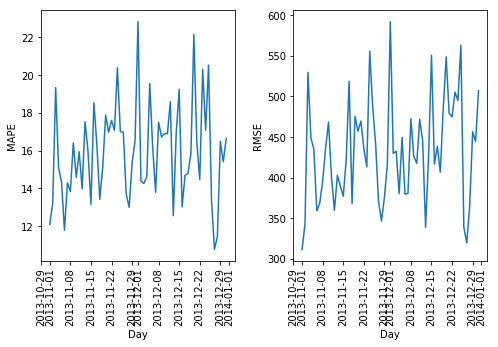

In [161]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
fig.subplots_adjust(bottom=0.3,wspace = 0.3)
error = ["MAPE","RMSE"]
cnt = 0
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.xlabel("Day")
    plt.ylabel(error[cnt])
    cnt += 1
ax1.plot(DF)
ax2.plot(DF1)

In [162]:
from statistics import mean
print("Mean RMSE = {}, Mean Mape = {}".format(mean(rmse_date),mean(Mape_date)))

Mean RMSE = 433.1813969876743, Mean Mape = 15.933571153891874


In [ ]:
actual_predicted = aggregate_df.where((aggregate_df.date==date(2013,11,29))).select("label","prediction").toPandas()
actual_predicted.head()

In [ ]:
ax = actual_predicted.plot()
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (Kw/h)")